**Трофимов Михаил, ПМ22-1**

In [1]:
!pip install torchmetrics >> None
!pip install torchvision >> None

In [22]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchmetrics as M
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import torchvision.models as models
import zipfile

In [3]:
def train_model(model, criterion, optimizer, metric, file_name, train, test, batch_size, num_epoch):
    th.manual_seed(42)

    loader = DataLoader(train, batch_size = batch_size, shuffle = True)
    loader_test = DataLoader(test, batch_size = batch_size, shuffle = True)

    model = model.to('cuda')
    criterion = criterion.to('cuda')
    metric = metric.to('cuda')

    best_metric = 0
    epoch_losses = []
    test_metrics = []

    for epoch in tqdm(range(num_epoch), desc = 'Обучение'):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(loader)
        epoch_losses.append(epoch_loss)

        metric.reset()
        model.eval()
        with th.no_grad():
            for X_batch, y_batch in loader_test:
                X_batch = X_batch.to('cuda')
                y_batch = y_batch.to('cuda')
                y_pred = model(X_batch)
                metric.update(y_pred, y_batch)
        test_metric = metric.compute().cpu().item()
        test_metrics.append(test_metric)

        if test_metric > best_metric:
            best_metric = test_metric
            th.save(model, file_name)

    return epoch_losses, test_metrics

In [4]:
def show_image(image, file_name, classes_to_idx, mean, std):
    model = th.load(file_name, weights_only = False).to('cuda')
    model.eval()

    true_label = image[1]
    image_tensor = image[0].to('cuda')

    with th.no_grad():
        pred_idx = model(image_tensor.unsqueeze(0)).argmax(dim = 1).item()

    idx_to_class = {v: k for k, v in classes_to_idx.items()}
    pred_class = idx_to_class[pred_idx]
    true_class = idx_to_class[true_label]

    image_np = image_tensor.cpu().numpy().transpose((1, 2, 0))
    image_np = std * image_np + mean

    plt.title(f'Predict: {pred_class} | True: {true_class}')
    plt.imshow(image_np)
    plt.show()

# Задача 1

Для датасета Mnist с рукописными цифрами:
1. Реализуйте модель классификации без сверточных слоев (только с полносвязными). Возьмите какое-нибудь изображение из датасета, реализуйте сдвиг этого изображения на 5px влево и вправо так, чтобы визуально объект на изображении смещался. Посчитайте вероятности для каждого класса. Визуализируйте как меняются вероятности в зависимости от степени сдвига.
2. Сделайте то же самое с сетью со сверточными слоями. Сравните результаты.

In [27]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root = './data', train = True,
                                           download = True, transform = transform)
test_dataset  = torchvision.datasets.MNIST(root = './data', train = False,
                                           download = True, transform = transform)

print(f'Количество классов: {len(train_dataset.classes)}')
print(f'Размер картинки: {train_dataset[0][0].shape}')

Количество классов: 10
Размер картинки: torch.Size([1, 28, 28])


In [30]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features= 28 * 28, out_features = 64),
    nn.ReLU(),
    nn.Linear(in_features = 64, out_features = 10)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
metric = M.Accuracy(task = 'multiclass', num_classes = 10)

epoch_losses, accuracy_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                          metric = metric, file_name = 'n1_fc.pth', train = train_dataset,
                                          test = test_dataset, batch_size = 32, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [02:56<00:00, 17.61s/it]


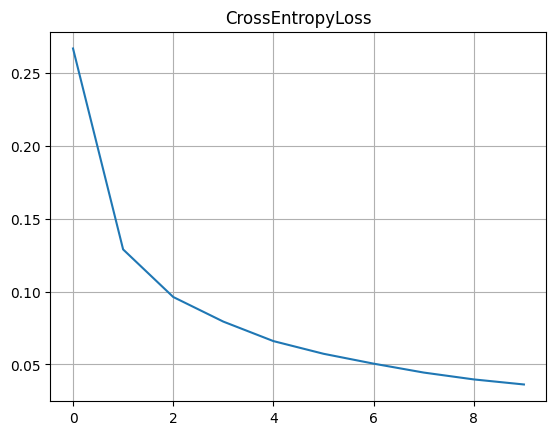

In [31]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

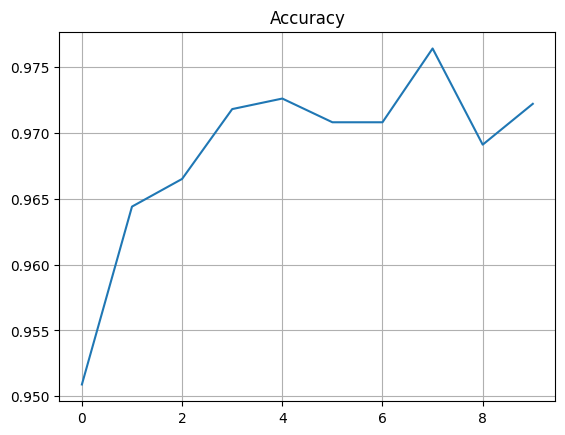

In [32]:
plt.title('Accuracy')
plt.plot(accuracy_test)
plt.grid(True)
plt.show()

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(784, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [34]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
metric = M.Accuracy(task = 'multiclass', num_classes = 10)

epoch_losses, accuracy_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                          metric = metric, file_name = 'n1_cnn.pth', train = train_dataset,
                                          test = test_dataset, batch_size = 32, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [02:45<00:00, 16.56s/it]


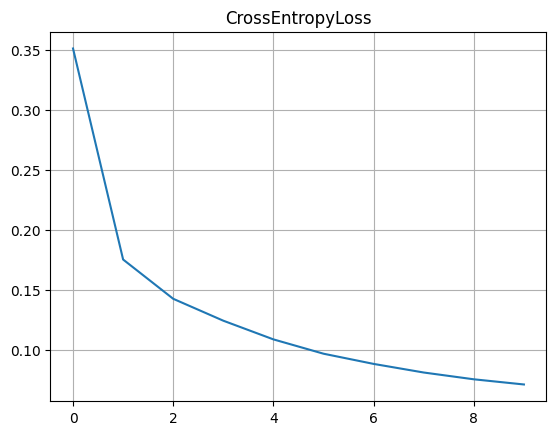

In [35]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

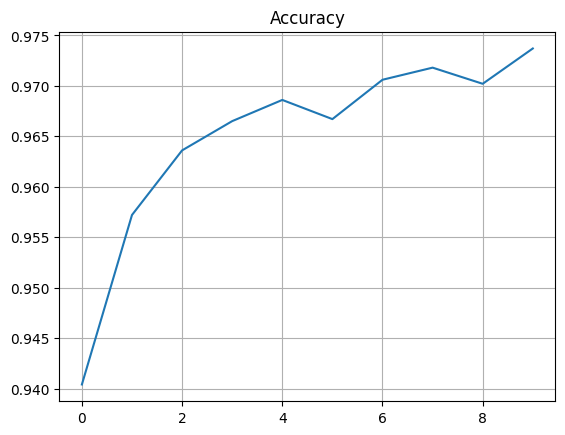

In [36]:
plt.title('Accuracy')
plt.plot(accuracy_test)
plt.grid(True)
plt.show()

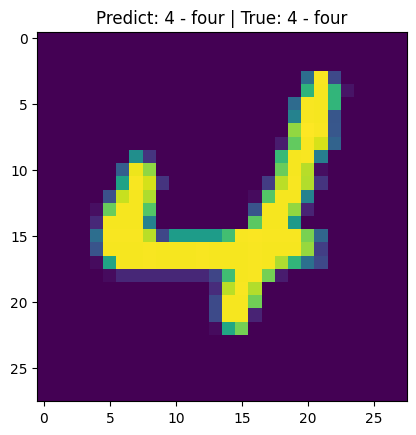

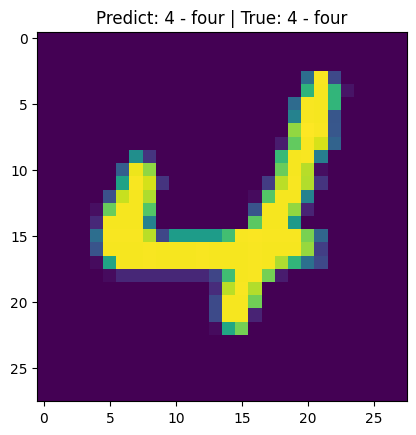

In [37]:
choice = randint(0, len(test_dataset))
show_image(test_dataset[choice], 'n1_fc.pth', classes_to_idx = test_dataset.class_to_idx,
           mean = (0.1307,), std = (0.3081,))
show_image(test_dataset[choice], 'n1_cnn.pth', classes_to_idx = test_dataset.class_to_idx,
           mean = (0.1307,), std = (0.3081,))

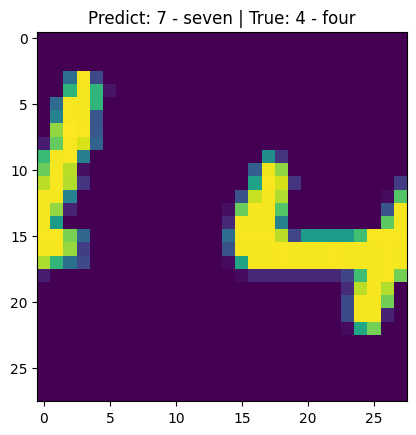

In [56]:
def shift(image, n):
    return th.cat((image[:, :, -n:], image[:, :, :-n]), dim = 2)

show_image((shift(test_dataset[choice][0], 10), test_dataset[choice][1]),
           'n1_fc.pth', classes_to_idx = test_dataset.class_to_idx,
           mean = (0.1307,), std = (0.3081,))

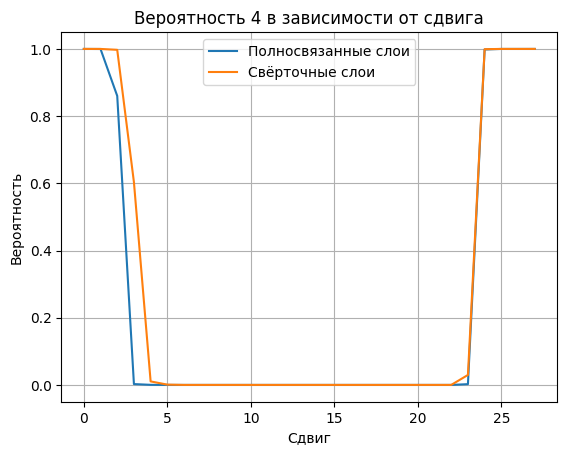

In [81]:
true_label = test_dataset[choice][1]
fc_pred = []
cnn_pred = []
softmax = nn.Softmax(dim = 1)

model_fc = th.load('n1_fc.pth', weights_only = False)
model_fc.eval()
model_cnn = th.load('n1_cnn.pth', weights_only = False)
model_cnn.eval()

for i in range(28):
    image = shift(test_dataset[choice][0].to('cuda').unsqueeze(0), i)
    fc_pred.append(softmax(model_fc(image)).cpu()[0][true_label].item())
    cnn_pred.append(softmax(model_cnn(image)).cpu()[0][true_label].item())

plt.title(f'Вероятность {true_label} в зависимости от сдвига')
plt.xlabel('Сдвиг')
plt.ylabel('Вероятность')
plt.plot(fc_pred, label = 'Полносвязанные слои')
plt.plot(cnn_pred, label = 'Свёрточные слои')
plt.legend()
plt.grid(True)
plt.show()

# Задача 2

Напишите модель классификации на предобученной сети resnet18 на Pytorch с заменой последнего полносвязного слоя для данных из [директории](https://drive.google.com/drive/folders/1r0PvRCsrqBpRe6bj1aw8bLwkEfAbC9lo?usp=sharing). Построить графики обучения и потерь.

In [13]:
with zipfile.ZipFile('cats_and_dogs.zip', 'r') as archive:
    archive.extractall()

In [14]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])

train = torchvision.datasets.ImageFolder(root = 'cats_and_dogs/train', transform = transform)
test = torchvision.datasets.ImageFolder(root = 'cats_and_dogs/test', transform = transform)

train.class_to_idx, test.class_to_idx

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

In [15]:
model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
model.fc = nn.Linear(in_features = 512, out_features = 2)
print(f'Число настраиваемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad == True)}')

Число настраиваемых параметров: 11177538


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
metric = M.Accuracy(task = 'multiclass', num_classes = 2)

epoch_losses, accuracy_test = train_model(model = model, criterion = criterion, optimizer = optimizer,
                                          metric = metric, file_name = 'n2.pth', train = train,
                                          test = test, batch_size = 32, num_epoch = 10)

Обучение: 100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


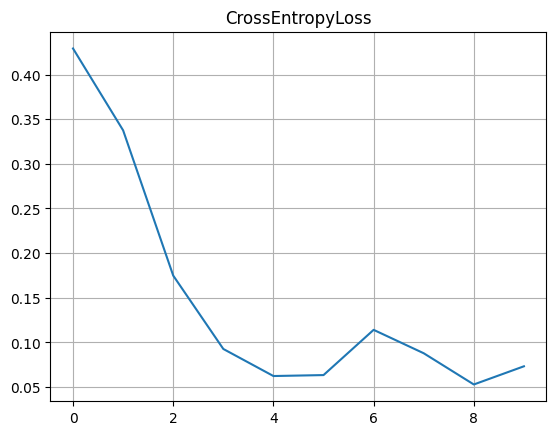

In [18]:
plt.title('CrossEntropyLoss')
plt.plot(epoch_losses)
plt.grid(True)
plt.show()

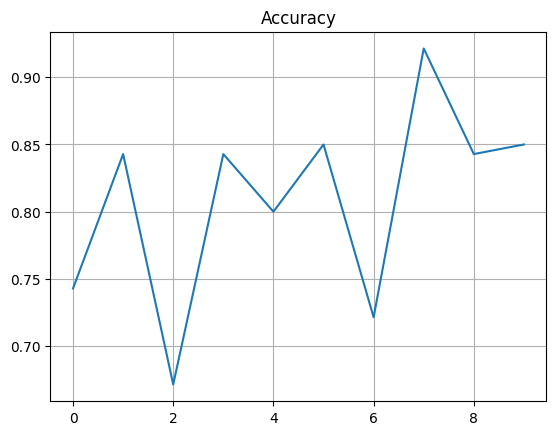

In [19]:
plt.title('Accuracy')
plt.plot(accuracy_test)
plt.grid(True)
plt.show()

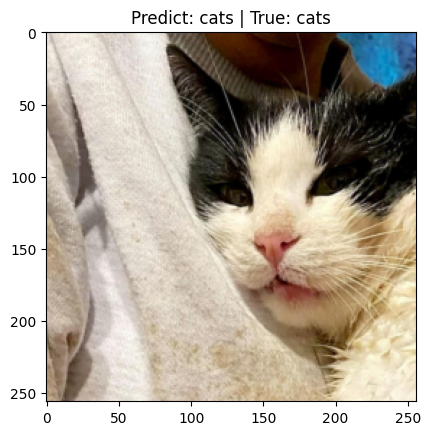

In [20]:
choice = randint(0, len(test))
show_image(test[choice], 'n2.pth', classes_to_idx = train.class_to_idx,
           mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))

# Задача 3 (показано на семинаре)

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) :
1. Изучить зависимость точности модели от разных размеров батча. Построить графики кривых обучения.
2. Изучить зависимость точности модели от разных оптимизаторов. Построить графики кривых обучения.

In [ ]:
with zipfile.ZipFile('data.zip', 'r') as archive:
    archive.extractall()

In [ ]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root = 'data', transform = transform)

dataset_loader = DataLoader(dataset, batch_size = 8)

n = len(dataset) * 64 * 64

mu = th.zeros((3,), dtype=th.float)
sig = th.zeros((3,), dtype=th.float)

for batch, _ in dataset_loader:
    for data in batch:
        mu += data.sum(dim = 1).sum(dim = 1)
        sig += (data**2).sum(dim = 1).sum(dim = 1)

mu = mu / n
sig = th.sqrt(sig / n - mu**2)

transform_new = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean = mu, std = sig)
])

dataset = torchvision.datasets.ImageFolder(root = 'data', transform = transform_new)

print(f'Картинок в датасете: {len(dataset)}')
print(f'Количество классов: {len(dataset.classes)}')
print(f'Размер картинки: {dataset[0][0].shape}')

th.manual_seed(42)
train, test = random_split(dataset, [0.8, 0.2])
cti = dataset.class_to_idx

Картинок в датасете: 2226
Количество классов: 4
Размер картинки: torch.Size([3, 64, 64])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(2048, 4)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Обучение: 100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


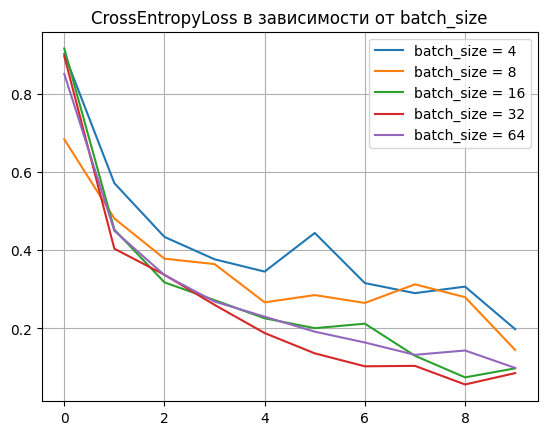

In [ ]:
batches = [4, 8, 16, 32, 64]
losses = []

for b in batches:
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr = 0.01)
    metric = M.F1Score(task = 'multiclass', num_classes = 4)
    losses.append(train_model(model = model, criterion = criterion, optimizer = optimizer,
                              metric = metric, file_name = 'what.pth', train = train,
                              test = test, batch_size = b, num_epoch = 10)[0])

plt.title('CrossEntropyLoss в зависимости от batch_size')
for i in range(len(batches)):
    plt.plot(losses[i], label = f'batch_size = {batches[i]}')
plt.legend()
plt.grid(True)
plt.show()

Обучение: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


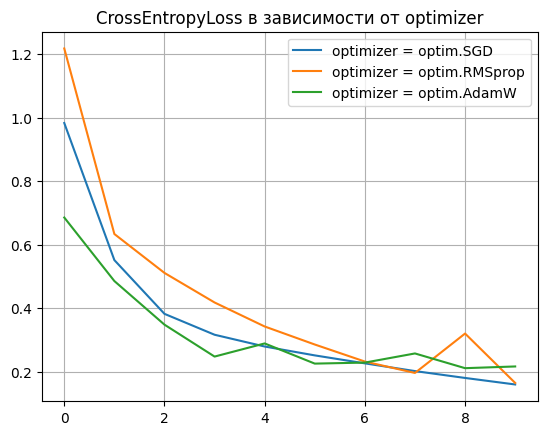

In [ ]:
optimizers = ['optim.SGD', 'optim.RMSprop', 'optim.AdamW']
losses = []

for opt in optimizers:
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = eval(opt)
    optimizer = optimizer(model.parameters(), lr = 0.01)
    metric = M.F1Score(task = 'multiclass', num_classes = 4)
    losses.append(train_model(model = model, criterion = criterion, optimizer = optimizer,
                              metric = metric, file_name = 'what.pth', train = train,
                              test = test, batch_size = 8, num_epoch = 10)[0])

plt.title('CrossEntropyLoss в зависимости от optimizer')
for i in range(len(optimizers)):
    plt.plot(losses[i], label = f'optimizer = {optimizers[i]}')
plt.legend()
plt.grid(True)
plt.show()